# **전처리 과정**



In [ ]:
import nltk
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import math

## Download Resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("vader_lexicon")

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from google.colab import drive
drive.mount('/content/drive')

# Progress bar
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
from umap import UMAP
from collections import Counter

# Set global random seed
RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/airlines_reviews.csv')
texts = df['Reviews'].astype(str)

In [ ]:
# Preprocessing
punct = set(string.punctuation)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in punct]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df['processed_final'] = df['Reviews'].astype(str).apply(preprocess)

# Preprocessed dataset
df_preprocessed = df.copy()
df_preprocessed

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,processed_final
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes,flight amazing crew onboard flight welcoming g...
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no,booking emergency exit seat still meant huge d...
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes,excellent performance front would definitely c...
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes,pretty comfortable flight considering flying e...
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes,service consistently good start finish cabin c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,an uneventful flight,N Vickers,2016-06-20,Korean Air,True,"KE124, Brisbane to Incheon (A330) and KE867,...",Business,June 2016,BNE to ULN via ICN,Economy Class,5,4,5,3,4,7,yes,ke brisbane incheon ke incheon ulaanbaatar kor...
8096,Korean Air always impresses,Kim Holloway,2016-06-12,Korean Air,False,Our recent flight was our fourth trip to the...,Couple Leisure,June 2016,SYD to LHR via ICN,Economy Class,3,5,5,4,5,10,yes,recent flight fourth trip uk year sydney londo...
8097,didn’t offer anything,C Clark,2016-06-06,Korean Air,True,I flew Korean Air from Bali to Seoul in Pres...,Business,April 2016,DPS to ICN,Business Class,4,5,5,5,1,2,no,flew korean air bali seoul prestige class busi...
8098,appreciated the service onboard,E Petan,2016-04-21,Korean Air,False,Seoul to Paris with Korean Air. I am traveli...,Business,April 2016,ICN to CDG,Business Class,5,1,3,4,5,10,yes,seoul paris korean air traveling triathlon bik...


# **Polarity 계산**

In [ ]:
# Drop unnecessary columns and not verified data
df_final = df_preprocessed.drop(['Title', 'Name', 'Review Date', 'Type of Traveller', 'Month Flown', 'Route'], axis=1).query("Verified == 'True'")
df_final = df_final.assign(Recommended=lambda x: x['Recommended'].map({'yes': 1, 'no': 0}))
df_final = df_final.reset_index(drop=True)

# Since we only kept the verified data(rows), drop the column as we don't need it anymore
df_final = df_final.drop(['Verified'], axis=1)
df_final

,Airline,Reviews,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,processed_final
0,Singapore Airlines,Flight was amazing. The crew onboard this fl...,Business Class,4,4,4,4,4,9,1,flight amazing crew onboard flight welcoming g...
1,Singapore Airlines,Booking an emergency exit seat still meant h...,Economy Class,5,3,4,4,1,3,0,booking emergency exit seat still meant huge d...
2,Singapore Airlines,Excellent performance on all fronts. I would...,Economy Class,1,5,2,1,5,10,1,excellent performance front would definitely c...
3,Singapore Airlines,Pretty comfortable flight considering I was f...,Economy Class,5,5,5,5,5,10,1,pretty comfortable flight considering flying e...
4,Singapore Airlines,The service was consistently good from start ...,Economy Class,5,5,5,5,5,10,1,service consistently good start finish cabin c...
...,...,...,...,...,...,...,...,...,...,...,...
6211,Korean Air,New York JFK to Tashkent via Seoul Incheon. ...,Business Class,4,5,3,4,1,1,0,new york jfk tashkent via seoul incheon worst ...
6212,Korean Air,First time flying out of the country from Sa...,Economy Class,4,5,4,4,5,10,1,first time flying country san francisco incheo...
6213,Korean Air,Flown from Seattle to Incheon and then Incheo...,Economy Class,3,4,5,4,3,7,1,flown seattle incheon incheon singapore korean...
6214,Korean Air,"KE124, Brisbane to Incheon (A330) and KE867,...",Economy Class,5,4,5,3,4,7,1,ke brisbane incheon ke incheon ulaanbaatar kor...


In [ ]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    # Instantiate an instance to access SentimentIntensityAnalyzer class
    # from vader in nltk
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf

    else:
        for sentence in tqdm(sentences):
            print("\n" + sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [ ]:
reviews = df_final['Reviews'].values

# Dataframe with airlines, reviews and vader scores
df_vader = evalSentences(df_final['Reviews'].values, to_df=True, columns=['review','vader_score'])
df_vader = pd.concat([df_final['Airline'], df_vader], axis=1)
df_vader

100%|██████████| 6216/6216 [00:09<00:00, 644.12it/s]


,Airline,review,vader_score
0,Singapore Airlines,Flight was amazing. The crew onboard this fl...,0.9755
1,Singapore Airlines,Booking an emergency exit seat still meant h...,-0.8957
2,Singapore Airlines,Excellent performance on all fronts. I would...,0.7506
3,Singapore Airlines,Pretty comfortable flight considering I was f...,0.9621
4,Singapore Airlines,The service was consistently good from start ...,0.9523
...,...,...,...
6211,Korean Air,New York JFK to Tashkent via Seoul Incheon. ...,0.8244
6212,Korean Air,First time flying out of the country from Sa...,0.8555
6213,Korean Air,Flown from Seattle to Incheon and then Incheo...,0.8793
6214,Korean Air,"KE124, Brisbane to Incheon (A330) and KE867,...",0.2500


# **Supervised Learning: Binary Classification**

In [ ]:
# Add columns from vader dataframe to the final dataframe
df_final = pd.concat([df_final, df_vader[['vader_score']]], axis=1)
df_final

,Airline,Reviews,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,processed_final,vader_score
0,Singapore Airlines,Flight was amazing. The crew onboard this fl...,Business Class,4,4,4,4,4,9,1,flight amazing crew onboard flight welcoming g...,0.9755
1,Singapore Airlines,Booking an emergency exit seat still meant h...,Economy Class,5,3,4,4,1,3,0,booking emergency exit seat still meant huge d...,-0.8957
2,Singapore Airlines,Excellent performance on all fronts. I would...,Economy Class,1,5,2,1,5,10,1,excellent performance front would definitely c...,0.7506
3,Singapore Airlines,Pretty comfortable flight considering I was f...,Economy Class,5,5,5,5,5,10,1,pretty comfortable flight considering flying e...,0.9621
4,Singapore Airlines,The service was consistently good from start ...,Economy Class,5,5,5,5,5,10,1,service consistently good start finish cabin c...,0.9523
...,...,...,...,...,...,...,...,...,...,...,...,...
6211,Korean Air,New York JFK to Tashkent via Seoul Incheon. ...,Business Class,4,5,3,4,1,1,0,new york jfk tashkent via seoul incheon worst ...,0.8244
6212,Korean Air,First time flying out of the country from Sa...,Economy Class,4,5,4,4,5,10,1,first time flying country san francisco incheo...,0.8555
6213,Korean Air,Flown from Seattle to Incheon and then Incheo...,Economy Class,3,4,5,4,3,7,1,flown seattle incheon incheon singapore korean...,0.8793
6214,Korean Air,"KE124, Brisbane to Incheon (A330) and KE867,...",Economy Class,5,4,5,3,4,7,1,ke brisbane incheon ke incheon ulaanbaatar kor...,0.2500


In [ ]:
# Before applying any models, text data (preprocessed_review) should be converted as numerical features
# Apply text vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_final['processed_final'])
y = df_final['Recommended']

# Divide the dataset using train_test_split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-------Shape of train-test data---------")
print(f'Train feature shape: {X_train.shape}')
print(f'Test feature shape: {X_test.shape}')

-------Shape of train-test data---------
Train feature shape: (4972, 16390)
Test feature shape: (1244, 16390)


In [ ]:
# Divide the dataset using train_test_split (80% train, 20% test) for VADER
X_vader = df_final[['vader_score']]
y_vader = df_final['Recommended']

X_train_vader, X_test_vader, y_train_vader, y_test_vader = train_test_split(X_vader, y_vader, test_size=0.2, random_state=42)

print("-------Shape of train-test VADER data---------")
print(f'Train feature shape: {X_train_vader.shape}')
print(f'Test feature shape: {X_test_vader.shape}')

-------Shape of train-test VADER data---------
Train feature shape: (4972, 1)
Test feature shape: (1244, 1)


# **Model Comparison**

## 1. Logistic Regression

=== Logistic Regression Evaluation Results ===
Accuracy: 0.885048231511254
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       595
           1       0.90      0.88      0.89       649

    accuracy                           0.89      1244
   macro avg       0.88      0.89      0.88      1244
weighted avg       0.89      0.89      0.89      1244



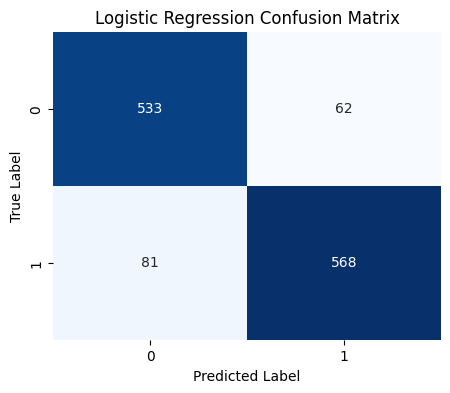

In [ ]:
# Build Logistic Regression model
logreg = LogisticRegression(random_state = 42)

# Train the model
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Compute accuracy score
acc_logreg = accuracy_score(y_test, y_pred)

# Print evaluation results
print("=== Logistic Regression Evaluation Results ===")
print("Accuracy:", acc_logreg)
print(classification_report(y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 2. Logistic Regression using VADER

=== Logistic Regression using VADER Evaluation Results ===
Accuracy: 0.8496784565916399
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       595
           1       0.83      0.90      0.86       649

    accuracy                           0.85      1244
   macro avg       0.85      0.85      0.85      1244
weighted avg       0.85      0.85      0.85      1244



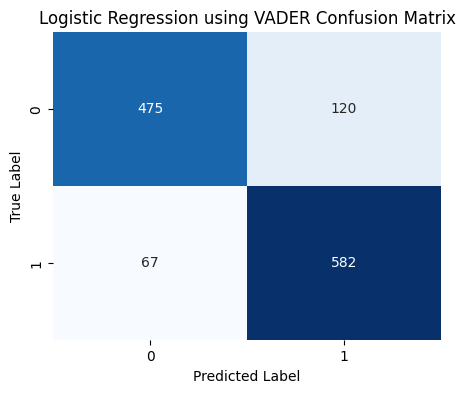

In [ ]:
# Build Logistic Regression model using VADER
logreg_vader = LogisticRegression(random_state = 42)

# Train the model
logreg_vader.fit(X_train_vader, y_train_vader)

# Predict on test set
y_pred_vader = logreg_vader.predict(X_test_vader)

# Compute accuracy score
acc_logreg_vader = accuracy_score(y_test_vader, y_pred_vader)

# Print evaluation results
print("=== Logistic Regression using VADER Evaluation Results ===")
print("Accuracy:", acc_logreg_vader)
print(classification_report(y_test_vader, y_pred_vader))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test_vader, y_pred_vader)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Logistic Regression using VADER Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 3. Random Forest

=== Random Forest Classifier Evaluation Results ===
Accuracy: 0.8810289389067524
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       595
           1       0.88      0.90      0.89       649

    accuracy                           0.88      1244
   macro avg       0.88      0.88      0.88      1244
weighted avg       0.88      0.88      0.88      1244



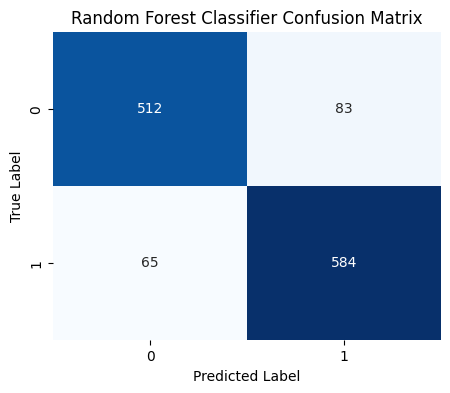

In [ ]:
# Feature scaling: ensures all the features are on a similar scale
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rfc = rfc.predict(X_test_scaled)

# Compute accuracy score
acc_rfc = accuracy_score(y_test, y_pred_rfc)

# Print evaluation results
print("=== Random Forest Classifier Evaluation Results ===")
print("Accuracy:", acc_rfc)
print(classification_report(y_test, y_pred_rfc))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 4. Bernoulli Naïve Bayes

=== Bernoulli Naive Bayes Evaluation Results ===
Accuracy: 0.8344051446945338
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       595
           1       0.80      0.90      0.85       649

    accuracy                           0.83      1244
   macro avg       0.84      0.83      0.83      1244
weighted avg       0.84      0.83      0.83      1244



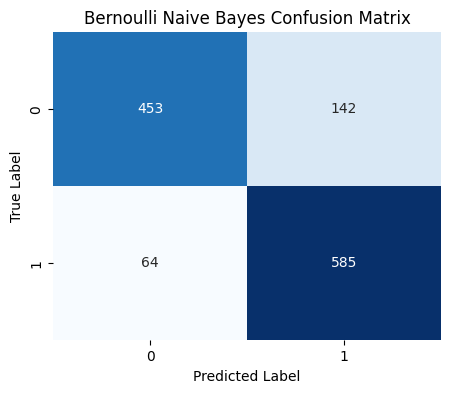

In [ ]:
# Build the Bernoulli Naive Bayes model
bnb = BernoulliNB()

# Train the model
bnb.fit(X_train, y_train)

# Predict on test set
y_pred_bnb = bnb.predict(X_test)

# Compute accuracy score
acc_bnb = accuracy_score(y_test, y_pred_bnb)

# Print evaluation results
print("=== Bernoulli Naive Bayes Evaluation Results ===")
print("Accuracy:", acc_bnb)
print(classification_report(y_test, y_pred_bnb))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred_bnb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Bernoulli Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 5. Linear Support Vector Machine (SVM)

=== Linear Support Vector Machine Evaluation Results ===
Accuracy: 0.8705787781350482
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       595
           1       0.89      0.86      0.87       649

    accuracy                           0.87      1244
   macro avg       0.87      0.87      0.87      1244
weighted avg       0.87      0.87      0.87      1244



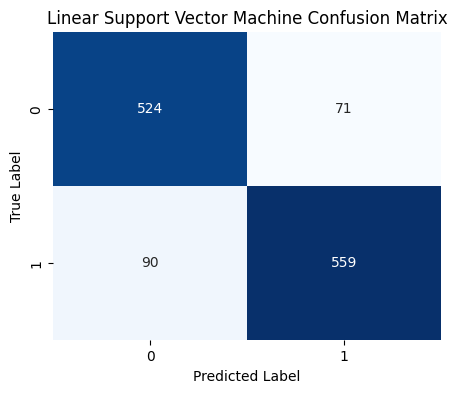

In [ ]:
# Build the Linear Support Vector Machine model
lsvm = svm.LinearSVC()

# Train the model
lsvm.fit(X_train, y_train)

# Predict on test set
y_pred_lsvm = lsvm.predict(X_test)

# Compute accuracy score
acc_lsvm = accuracy_score(y_test, y_pred_lsvm)

# Print evaluation results
print("=== Linear Support Vector Machine Evaluation Results ===")
print("Accuracy:", acc_lsvm)
print(classification_report(y_test, y_pred_lsvm))

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred_lsvm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Linear Support Vector Machine Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Compare the accuracy score

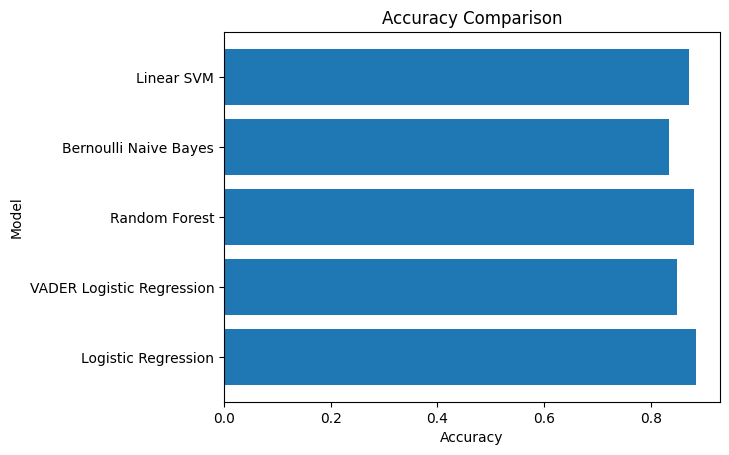

In [ ]:
model = ['Logistic Regression', 'VADER Logistic Regression', 'Random Forest', 'Bernoulli Naive Bayes', 'Linear SVM']
accuracy = [acc_logreg, acc_logreg_vader, acc_rfc, acc_bnb, acc_lsvm]

plt.barh(model, accuracy)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# **Class Comparison**

In [ ]:
# Build Logistic Regression model
logreg_final = LogisticRegression(random_state = 42)

# Train the model
logreg_final.fit(X_train, y_train)

# Predict on the whole dataset
X_all = vectorizer.transform(df_final['Reviews'])
df_final['pos_rate'] = logreg_final.predict(X_all)

# Predict probability on test set
df_final['pos_prob'] = logreg_final.predict_proba(X_all)[:, 1]

# Create new dataframe
df_class = (
    df_final.groupby(['Airline', 'Class'])
    .agg(
        positive_rate = ('pos_rate', 'mean'),
        positive_probability = ('pos_prob', 'mean'),
        )
    .reset_index()
    .sort_values(['Airline','Class'])
)

df_class

,Airline,Class,positive_rate,positive_probability
0,Air France,Business Class,0.552000,0.554999
1,Air France,Economy Class,0.375870,0.396933
2,Air France,First Class,1.000000,0.993719
3,Air France,Premium Economy,0.392157,0.422024
4,All Nippon Airways,Business Class,0.695652,0.723300
5,All Nippon Airways,Economy Class,0.835938,0.834428
6,All Nippon Airways,First Class,0.833333,0.900377
7,All Nippon Airways,Premium Economy,0.750000,0.731328
8,Cathay Pacific Airways,Business Class,0.706667,0.712262
9,Cathay Pacific Airways,Economy Class,0.557522,0.561981


In [ ]:
# Combine positive_rate score and positive_probability score
df_class['positive_score'] = df_class['positive_rate'] * df_class['positive_probability']

# Print the dataframe for each class
for cls in df_class['Class'].unique():
    print(f'\n===== Top Airlines Ranking for {cls}=====\n')

    df_rank = df_class[df_class['Class'] == cls].sort_values('positive_score', ascending=False).reset_index(drop=True)
    df_rank['Rank'] = df_rank.index + 1
    df_rank = df_rank.set_index('Rank')
    display(df_rank[['Airline', 'positive_score']])


===== Top Airlines Ranking for Business Class=====



,Airline,positive_score
Rank,,
1,EVA Air,0.808904
2,Qatar Airways,0.608709
3,Singapore Airlines,0.561179
4,Cathay Pacific Airways,0.503331
5,All Nippon Airways,0.503165
6,Japan Airlines,0.415179
7,Emirates,0.394210
8,Korean Air,0.330021
9,Air France,0.306359



===== Top Airlines Ranking for Economy Class=====



,Airline,positive_score
Rank,,
1,All Nippon Airways,0.697529
2,Japan Airlines,0.492824
3,Qatar Airways,0.454473
4,EVA Air,0.453979
5,Singapore Airlines,0.403797
6,Korean Air,0.395071
7,Cathay Pacific Airways,0.313317
8,Air France,0.149195
9,Emirates,0.108896



===== Top Airlines Ranking for First Class=====



,Airline,positive_score
Rank,,
1,Air France,0.993719
2,Japan Airlines,0.990708
3,Singapore Airlines,0.812258
4,All Nippon Airways,0.750314
5,Qatar Airways,0.655735
6,Cathay Pacific Airways,0.535842
7,Emirates,0.452936
8,Korean Air,0.000000
9,Turkish Airlines,0.000000



===== Top Airlines Ranking for Premium Economy=====



,Airline,positive_score
Rank,,
1,Qatar Airways,0.998446
2,EVA Air,0.656764
3,All Nippon Airways,0.548496
4,Japan Airlines,0.508016
5,Cathay Pacific Airways,0.393611
6,Singapore Airlines,0.375746
7,Emirates,0.170017
8,Air France,0.165499
9,Turkish Airlines,0.000000


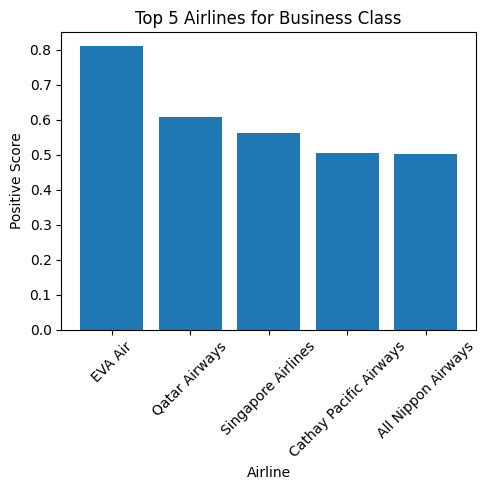

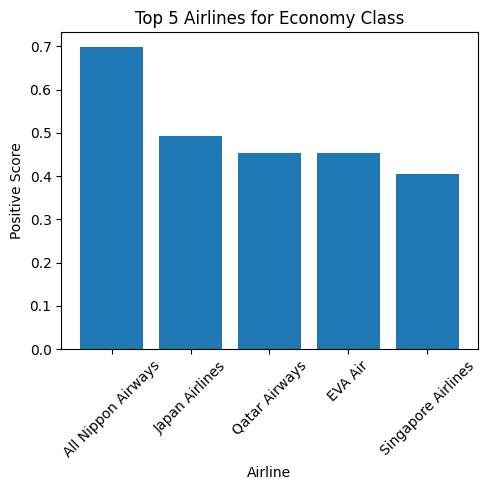

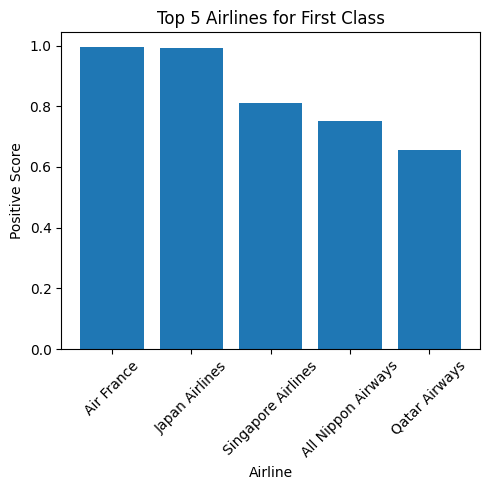

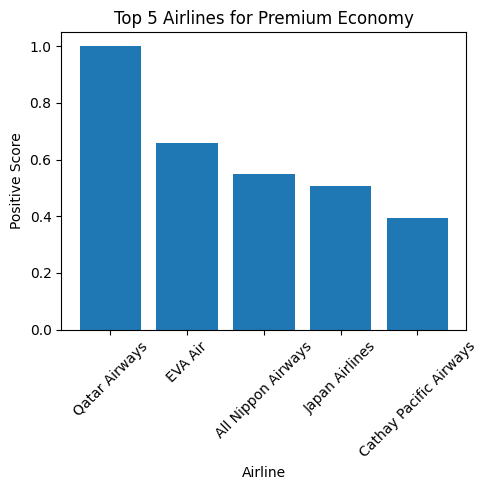

In [ ]:
# Display top 5 Airlines for each class
for cls in df_class['Class'].unique():
  top5 = df_class[df_class['Class'] == cls].sort_values('positive_score', ascending=False).head(5)

  plt.figure(figsize=(5, 5))
  plt.bar(top5['Airline'], top5['positive_score'])
  plt.title(f'Top 5 Airlines for {cls}')
  plt.xlabel('Airline')
  plt.ylabel('Positive Score')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

#**Compare the Details**

In [ ]:
# Only extract columns with numeric value
num_cols = df_final.select_dtypes(include=['int64']).columns.tolist()

# Drop Recommended and pos_rate column (unneeded)
remove_cols = ['Recommended', 'pos_rate']
num_cols = [col for col in num_cols if col not in remove_cols]

ranking_per_column = {}

for col in num_cols:
  df_avg = df_final.groupby('Airline')[col].mean().sort_values(ascending=False).reset_index()

  df_avg['Rank'] = df_avg.index + 1
  df_avg = df_avg.set_index('Rank')
  ranking_per_column[col] = df_avg

for col, table in ranking_per_column.items():
  print(f'\n===== Top Airlines Ranking for {col} =====\n')
  display(table)


===== Top Airlines Ranking for Seat Comfort =====



,Airline,Seat Comfort
Rank,,
1,All Nippon Airways,4.140000
2,Qatar Airways,3.955759
3,EVA Air,3.920561
4,Japan Airlines,3.877301
5,Singapore Airlines,3.668442
6,Korean Air,3.636364
7,Cathay Pacific Airways,3.598230
8,Emirates,3.128385
9,Air France,2.920195



===== Top Airlines Ranking for Staff Service =====



,Airline,Staff Service
Rank,,
1,All Nippon Airways,4.515000
2,Qatar Airways,4.291381
3,EVA Air,4.191589
4,Japan Airlines,4.141104
5,Singapore Airlines,3.902796
6,Korean Air,3.825758
7,Cathay Pacific Airways,3.596460
8,Air France,3.298046
9,Emirates,2.939819



===== Top Airlines Ranking for Food & Beverages =====



,Airline,Food & Beverages
Rank,,
1,All Nippon Airways,4.015000
2,Qatar Airways,3.932876
3,EVA Air,3.845794
4,Japan Airlines,3.785276
5,Korean Air,3.537879
6,Singapore Airlines,3.536618
7,Cathay Pacific Airways,3.175221
8,Air France,3.094463
9,Turkish Airlines,2.972419



===== Top Airlines Ranking for Inflight Entertainment =====



,Airline,Inflight Entertainment
Rank,,
1,Qatar Airways,4.130435
2,All Nippon Airways,3.890000
3,Singapore Airlines,3.882823
4,Cathay Pacific Airways,3.789381
5,EVA Air,3.785047
6,Emirates,3.670010
7,Japan Airlines,3.521472
8,Korean Air,3.272727
9,Air France,3.174267



===== Top Airlines Ranking for Value For Money =====



,Airline,Value For Money
Rank,,
1,All Nippon Airways,4.085000
2,EVA Air,3.929907
3,Qatar Airways,3.711670
4,Japan Airlines,3.687117
5,Korean Air,3.469697
6,Singapore Airlines,3.452730
7,Cathay Pacific Airways,3.320354
8,Emirates,2.674022
9,Air France,2.672638



===== Top Airlines Ranking for Overall Rating =====



,Airline,Overall Rating
Rank,,
1,All Nippon Airways,7.850000
2,EVA Air,7.224299
3,Qatar Airways,7.072464
4,Japan Airlines,6.858896
5,Singapore Airlines,6.549933
6,Korean Air,6.136364
7,Cathay Pacific Airways,6.099115
8,Air France,4.664495
9,Emirates,4.520562


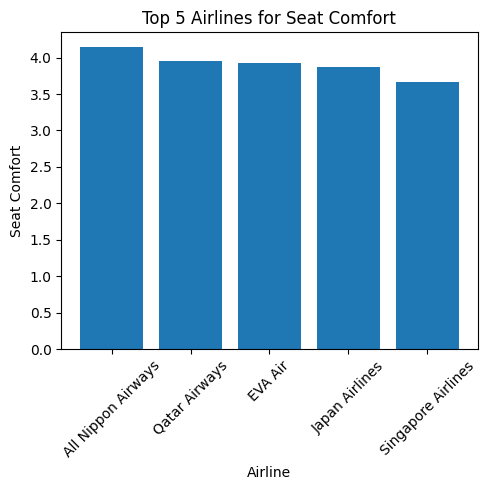

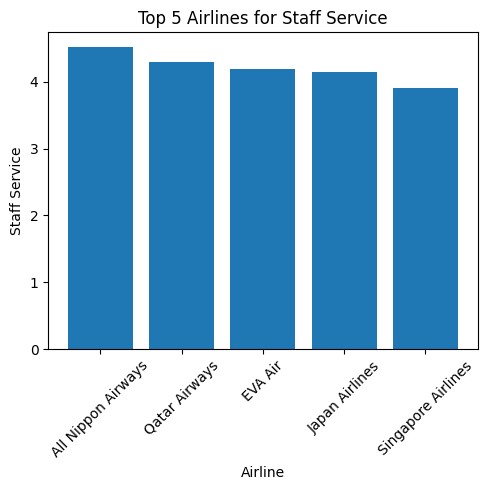

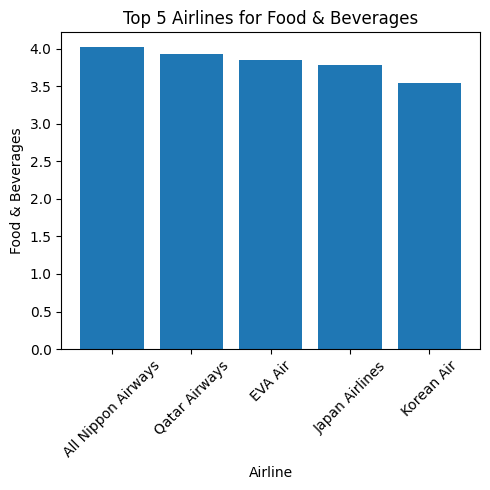

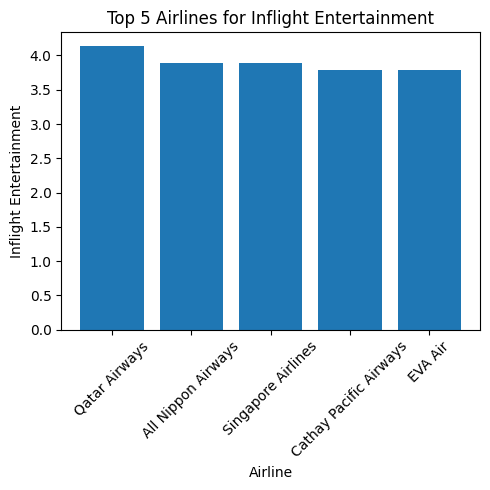

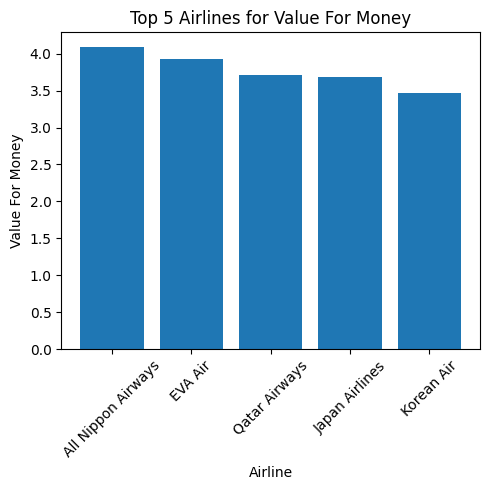

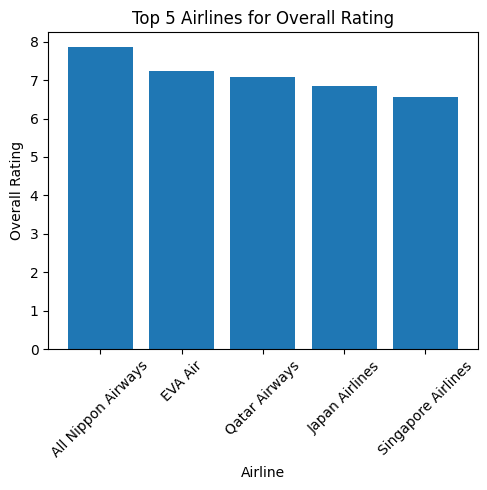

In [ ]:
# Display top 5 Airlines for each characteristics
for col, table in ranking_per_column.items():
  top5 = table.head(5)

  plt.figure(figsize=(5, 5))
  plt.bar(top5['Airline'], top5[col])
  plt.title(f'Top 5 Airlines for {col}')
  plt.xlabel('Airline')
  plt.ylabel(col)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()